In [1]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# plt.style.use('dark_background')

from modules import ELBO, direct_estimation
from utils import load_sim_data

import os
import matlab.engine

### Setup parameters

In [2]:
N = 5
sim_curvature = 20 # simulated average curvature (in degrees)
n_trials = 1000

# whether to load stored data or simulate data by calling the simulation_py.mat function directly
load_from_matlab = True

In [3]:
data_path = '/Users/nguyentiendung/GitHub/perceptual-straightening/data/simulations/'
sim_path = '/Users/nguyentiendung/GitHub/perceptual-straightening/simulations/'
out_dict = '/Users/nguyentiendung/GitHub/perceptual-straightening/model/'

### Run direct estimation algorithm (Maximum Likelihood) to initialize posterior probabilities

In [4]:
c_est, c_true, c, d, a, ExpParam, Data = direct_estimation(sim_path, n_traj=1, n_frames=N, n_dim=N-1, n_iterations=1000, n_trials=n_trials, sim_curvature=sim_curvature)

Trajectory: 0


In [5]:
# create initial values
# d_post_init = d.squeeze() + torch.randn(d.squeeze().size())
d_post_init = d.squeeze()

c_post_init = torch.zeros(N-1)
c_post_init[1:] = c.squeeze() 
# c_post_init[0] = torch.mean(c)
# c_post_init += torch.randn(c_post_init.size()) * 0.1
# c_post_init = torch.zeros(1, N-1)
# c_post_init[:, 1:] = c 
# c_post_init[:, 0] = torch.mean(c)
# c_post_init += torch.randn(c_post_init.size()) * 0.1
# U, S, _ = torch.linalg.svd(torch.cov(c_post_init.t() @ c_post_init))
# c_post_init = U @ torch.diag(torch.sqrt(S))[0,:].squeeze()
# c_post_init = c.squeeze() 
# c_post_init += torch.randn(c_post_init.size()) * 0.1

a_post_init = torch.zeros(N-1, N-1)
a_post_init[1:] = a.squeeze()
# a_post_init[0] = torch.mean(a.squeeze(), dim=0)

### Run inference

In [6]:
eps = 1e-6
sim_traj = 1 # number of trajectories to simulate (recovery analysis)
# model = ELBO(N, d_post_init, c_post_init, eps=eps)
model = ELBO(N, d_post_init, c_post_init, a_post_init, eps=eps)

lr = 1e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# model_file = Path(out_dict) / f'model_{sim_curvature}.pt'

#### Load behavioral data

In [7]:
 # load trial information
if load_from_matlab:
    os.chdir(sim_path)

    # # start MATLAB engine
    # eng = matlab.engine.start_matlab()
    # ExpParam, Data, Pc_reshaped = eng.simulation_py(sim_curvature, N, N-1, n_trials, nargout=3)

    # # stop MATLAB engine
    # eng.quit()

    # extract data matrices
    trial_mat = torch.tensor(Data['resp_mat'])
    pair_inds = torch.tensor(ExpParam['all_pairs'])
    print('Successfully loaded data from MATLAB script.') # data was generated in the direct_estimation() function

else:
    trial_mat = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'Data.mat')['Data']['resp_mat'][0][0]) 
    pair_inds = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'ExpParam.mat')['ExpParam']['all_pairs'][0][0]) 
    print('Successfully loaded data.')

Successfully loaded data from MATLAB script.


#### Optimize the whole ELBO

In [8]:
iterations = 20000

# errors
errors = np.zeros(iterations)
kl_loss = np.zeros(iterations)
ll_loss = np.zeros(iterations)

# variables
c_prior = np.zeros(iterations)
d_prior = np.zeros(iterations)
c_post = np.zeros((N-1, iterations))
# c_post = np.zeros((N-2, iterations))

best_iteration = 0
for i in range(iterations):
    
    # clear gradients
    optimizer.zero_grad()

    log_ll, d, c, a = model.compute_likelihood(trial_mat, pair_inds, n_samples=100)
    kl = model.kl_divergence()
    loss = model.compute_loss(log_ll, kl)

    # gradient update
    loss.backward()
    optimizer.step()

    # store errors for each iteration
    errors[i] = loss.item()
    kl_loss[i] = kl.item()
    ll_loss[i] = log_ll.item()
    c_prior[i] = model.mu_prior_c.detach().numpy()[0] * (180 / np.pi)
    d_prior[i] = model.mu_prior_d.detach().numpy()[0]
    c_post[:, i] = model.mu_post_c.detach().numpy() * (180 / np.pi)

    # print progress
    if not i % 250:
        print(f"Epoch: {i}, Loss: {loss.item()}")

# # save parameters
# phi_params = {'d': d_best,
#               'c': c_best,
#               'a': a_best}
# torch.save(phi_params, Path(data_path) / f'params_{sim_curvature}.pt')
# torch.save(model.state_dict(), model_file)

Epoch: 0, Loss: 228.1665496826172
Epoch: 250, Loss: 223.69717407226562
Epoch: 500, Loss: 219.54818725585938
Epoch: 750, Loss: 215.78639221191406
Epoch: 1000, Loss: 212.29139709472656
Epoch: 1250, Loss: 209.0966033935547
Epoch: 1500, Loss: 206.10533142089844
Epoch: 1750, Loss: 203.3489227294922
Epoch: 2000, Loss: 200.76177978515625
Epoch: 2250, Loss: 198.33056640625
Epoch: 2500, Loss: 196.03933715820312
Epoch: 2750, Loss: 193.87440490722656
Epoch: 3000, Loss: 191.81158447265625
Epoch: 3250, Loss: 189.83544921875
Epoch: 3500, Loss: 187.94570922851562
Epoch: 3750, Loss: 186.1203155517578
Epoch: 4000, Loss: 184.32077026367188
Epoch: 4250, Loss: 182.57968139648438
Epoch: 4500, Loss: 180.83595275878906
Epoch: 4750, Loss: 179.11131286621094
Epoch: 5000, Loss: 177.37088012695312
Epoch: 5250, Loss: 175.5890350341797
Epoch: 5500, Loss: 173.74400329589844
Epoch: 5750, Loss: 171.8154296875
Epoch: 6000, Loss: 169.74899291992188
Epoch: 6250, Loss: 167.5052947998047
Epoch: 6500, Loss: 165.00975036621

In [9]:
# for name, param in model.named_parameters():
#     print(f"{name}: is_leaf={param.is_leaf}, requires_grad={param.requires_grad}")

#### Load final model and plot error curves

In [10]:
# best_model = ELBO(N, data_path, eps)
# best_model.load_state_dict(torch.load(model_file, weights_only=True))

/opt/anaconda3/envs/vision/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


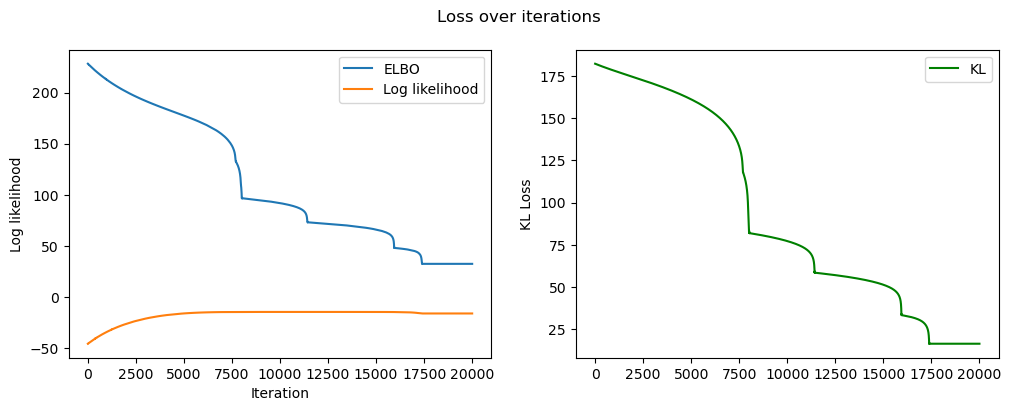

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Primary y-axis (ELBO and Neg. log likelihood)
axs[0].plot(errors, label='ELBO')
axs[0].plot(ll_loss, label='Log likelihood')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Log likelihood')
# axs[0].set_yscale('log')
# axs[0].tick_params(axis='y')

axs[1].plot(kl_loss, label='KL', color='green')
axs[1].set_ylabel('KL Loss')
# axs[1].tick_params(axis='y')
# axs[1].set_yscale('log')

# Add legends for both axes
axs[0].legend()
axs[1].legend()

# save and show the plot
fig.suptitle('Loss over iterations')
plt.savefig(Path(out_dict) / f"error_{sim_curvature}")
plt.show()

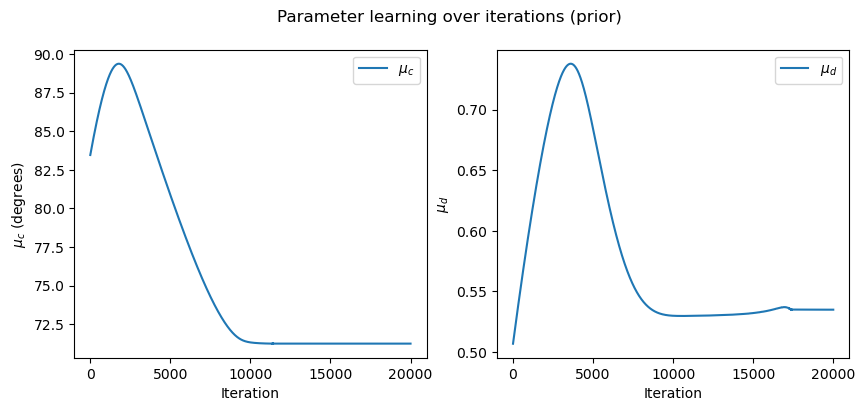

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

for i in range(2):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

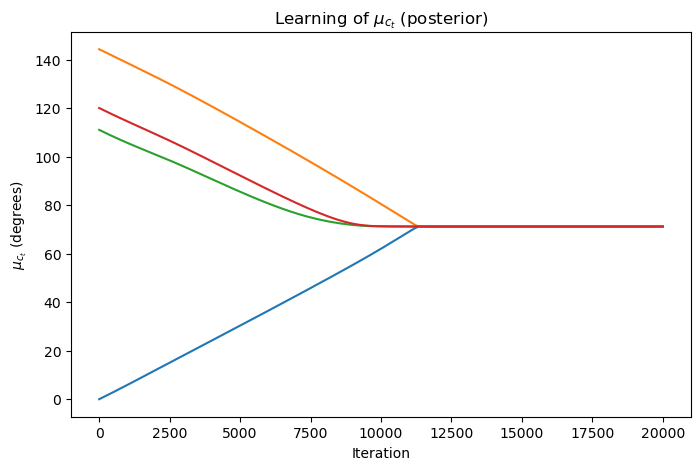

In [13]:
plt.figure(figsize=(8, 5))
# for i in range(N-2):
for i in range(N-1):
    plt.plot(c_post[i])
plt.title(r"Learning of $\mu_{c_t}$ (posterior)")
plt.ylabel(r'$\mu_{c_t}$ (degrees)')
plt.xlabel("Iteration")
plt.show()

In [14]:
# plt.plot(c_post[6])
# plt.show()

### Reconstruct trajectory

In [15]:
# est_global_curvature = best_model.mu_c.detach().numpy() * (180 / np.pi)
est_global_curvature = model.mu_prior_c.detach().numpy() * (180 / np.pi)
print(f'Estimated global curvature: {est_global_curvature[0]} degrees')
# print(f'Average estimated local curvature: {torch.mean(c_best).detach().numpy() * (180/np.pi)} degrees')
print(f'Average estimated local curvature: {torch.mean(c).detach().numpy() * (180/np.pi)} degrees')

Estimated global curvature: 71.24578857421875 degrees
Average estimated local curvature: 71.23704255253543 degrees


In [16]:
def run_pca(X, n_components=2):
    """
    Run PCA on the estimated trajectory. 

    Inputs:
    -------
    X: (n_dimensions x n_frames) torch tensor
        Input matrix (estimated trajectory)
    n_components: Scalar
        Number of fitted principle components

    Output:
    -------
    X_new: (n_frames x n_components) numpy array
        Transformed values
    """
    
    pca = PCA(n_components)
    pca.fit(X)
    return pca.components_

In [17]:
# if load_from_matlab:
#     # plot data
#     ax = sns.heatmap(Pc_reshaped, cmap='Blues')
#     ax.invert_yaxis()
#     plt.show()

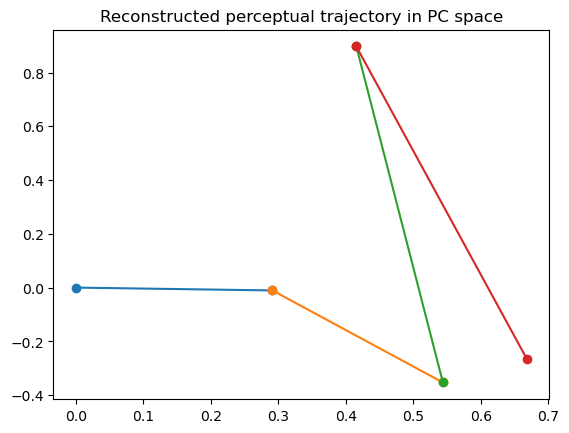

In [18]:
# run PCA to reduce the dimensionality of the trajectory
# x = torch.squeeze(best_model.construct_trajectory(torch.mean(d_best, dim=0, keepdim=True), 
#                                torch.mean(c_best, dim=0, keepdim=True), 
#                                torch.mean(a_best, dim=0, keepdim=True)))
x = torch.squeeze(model.construct_trajectory(torch.mean(d, dim=0, keepdim=True), 
                               torch.mean(c, dim=0, keepdim=True), 
                               torch.mean(a, dim=0, keepdim=True)))

pc = run_pca(x.t().detach().numpy())
for i in range(pc.shape[1]-1):
    plt.plot([pc[0, i], pc[0, i+1]], [pc[1, i], pc[1, i+1]], '-o')
plt.title('Reconstructed perceptual trajectory in PC space')
plt.show()

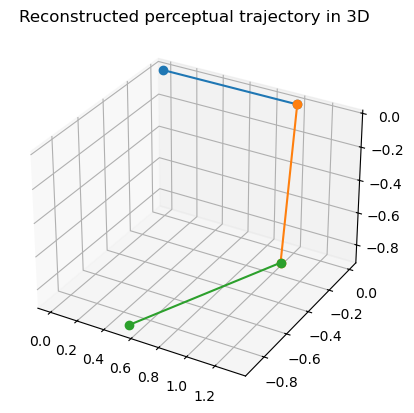

In [19]:
x_np = x.detach().numpy().T
fig = plt.figure()
if N-1 == 2:
    # visualize the perceptual trajectory for 2d 
    ax = fig.add_subplot(111)
    for i in range(x.shape[1]-1):
        plt.plot([x_np[0, i], x_np[0, i+1]], 
                 [x_np[1, i], x_np[1, i+1]],)
    plt.title('Reconstructed perceptual trajectory in 2D')
    plt.show()
elif N-1 >= 3:
    # visualize the perceptual trajectory for >= 3d (plotting first 3 dimensions)
    ax = fig.add_subplot(111, projection='3d')
    for i in range(x.shape[1]-1):
        plt.plot([x_np[0, i], x_np[0, i+1]], 
                 [x_np[1, i], x_np[1, i+1]],
                 [x_np[2, i], x_np[2, i+1]], '-o')
    plt.title('Reconstructed perceptual trajectory in 3D')
    plt.show()

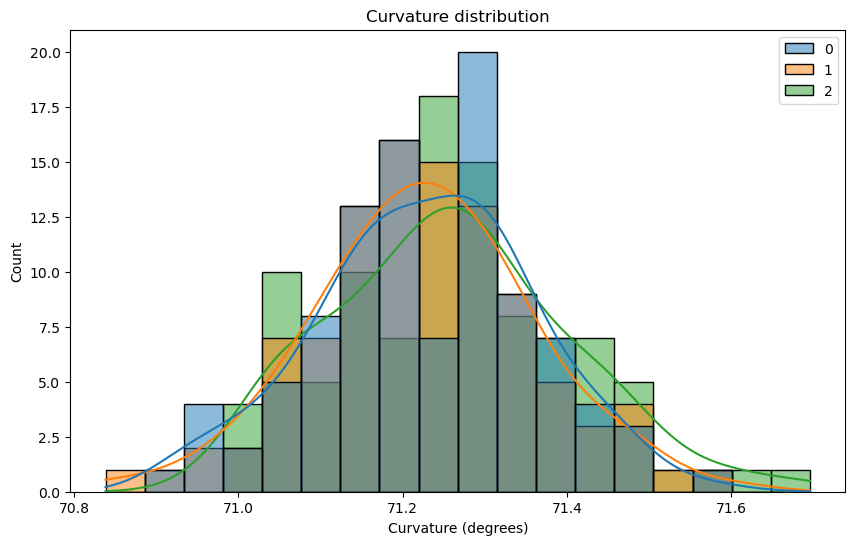

In [20]:
# plot histograms of trajectory variables
# fig, axs = plt.subplots(figsize=(10, 6))
# sns.histplot(c_best.detach().numpy() * (180 / np.pi), kde=True, ax=axs)
# axs.set_xlabel('Curvature (degrees)')
# axs.set_title('Curvature distribution')
# plt.show()
fig, axs = plt.subplots(figsize=(10, 6))
sns.histplot(c.detach().numpy() * (180 / np.pi), kde=True, ax=axs)
axs.set_xlabel('Curvature (degrees)')
axs.set_title('Curvature distribution')
plt.show()